In [42]:
from minee.data.mix_gaussian import MixedGaussian
import numpy as np
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Ideally, generate the tensor flow vector of the data once and for all.

In [311]:
np.random.seed(0)
n_samples = 2000
rho1 = 0.9
lr = 1e-3
data = MixedGaussian(n_samples=n_samples,rho1=rho1).data
data_t = torch.FloatTensor(data).to(device)

In [312]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('Agg')

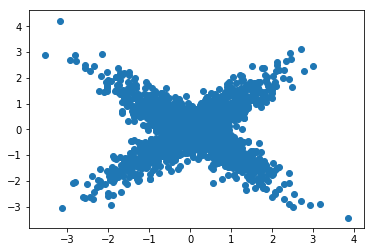

In [313]:
plt.scatter(data[:,0],data[:,1])

In [314]:
def getHeatMap(mine_net,data,grids=[50,50]):
    Xmin = min(data[:,0])
    Xmax = max(data[:,0])
    Ymin = min(data[:,1])
    Ymax = max(data[:,1])
    x = np.linspace(Xmin, Xmax, grids[0])
    y = np.linspace(Ymin, Ymax, grids[1])
    xs, ys = np.meshgrid(x,y)
    XY = np.array((xs,ys))
    Z=np.array([mine_net(torch.FloatTensor(XY[:,i,j]).to(device)).item() 
                for j in range(ys.shape[0]) 
                for i in range(xs.shape[1])]).reshape(xs.shape[1],ys.shape[0])
    plt.pcolormesh(xs,ys,Z,cmap='RdBu_r')

In [315]:
def sample_marginal(data,batch_size=100):
    joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=True)
    marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=True)
    return np.concatenate([data[joint_index][:,0].reshape(-1,1), data[marginal_index][:,1].reshape(-1,1)], axis=1)

In [316]:
import torch.nn as nn
import torch.nn.functional as F

In [317]:
sigma = .02
class MineNet(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=sigma)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [318]:
from torch import optim
# import torch.autograd as autograd

In [319]:
mine_net = MineNet()
mine_net.to(device)
mine_net_optim = optim.Adam(mine_net.parameters(),lr=1e-3)

In [320]:
from minee.model.mine import sample_batch

In [321]:
batch_size = n_samples

In [322]:
data_marginal = sample_batch(data,batch_size=n_samples,sample_mode='marginal')
data_marginal_t = torch.FloatTensor(data_marginal).to(device)

In [323]:
mi_estimate = []
ma_rate = 0.01

In [354]:
for j in range(1000):
    for i in range(10):
        mine_net_optim.zero_grad()
        batch_data = sample_batch(data,batch_size=batch_size,sample_mode='joint')
        batch_data_marginal = sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        #batch_data_marginal = np.random.multivariate_normal(mean=[0,0],cov=[[1,0],[0,1]],size=3000)
        batch_data_t = torch.FloatTensor(batch_data).to(device)
        batch_marginal_t = torch.FloatTensor(batch_data_marginal).to(device)
        t = mine_net(batch_data_t)
        et = torch.exp(mine_net(batch_marginal_t))
        mi_lb = torch.mean(t) - torch.log(torch.mean(et))
        loss = -mi_lb
        #ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
        #loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
        loss.backward()
        mine_net_optim.step()    
    mi_estimate = np.append(mi_estimate,(torch.mean(mine_net(data_t)) - torch.log(torch.mean(torch.exp(mine_net(data_marginal_t))))).item())

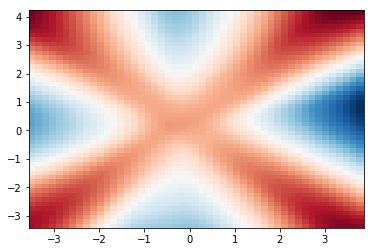

In [355]:
getHeatMap(mine_net,data,grids=[50,50])

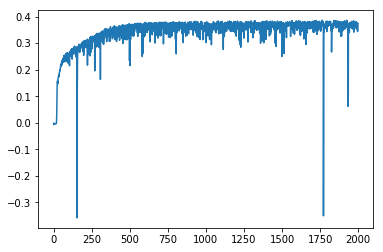

In [356]:
plt.plot(mi_estimate)